<a href="https://colab.research.google.com/github/JayAnnKay/Machine_Translation/blob/master/Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation

## Introduction
In this script, we attempt at translating German sequences to English using two RNNs.

Data source : http://www.manythings.org/anki/ 

The website contains a lot of sentence pair datasets.

# Summary 
------------------

# Data Preprocessing 
------------

In [0]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
from numpy import argmax

In [0]:
# import zipfile 
# zip = zipfile.ZipFile('deu-eng.zip')
# zip.extractall()

In [0]:
from google.colab import files


In [4]:
uploaded = files.upload()

Saving deu.txt to deu.txt


In [0]:
# files.download('deu.txt')

In [0]:
#We load the data in a way that it preserves the Unicode German characters.

def load_doc(filename):
    file = open(filename, mode ='rt') #mode - read text
    text = file.read() #read-only
    file.close()
    return text

In [0]:
# Each line contains a pair of English, German phrase. They are separated by a tab character.
#We remove the whitespace and first split the text by line and then by phrase

def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in lines]
    return pairs

### Data Cleaning

In [0]:
# We create a function that will perform the ollowing cleaning operations ~

# Remove all non-printable characters.
# Remove all punctuation characters.
# Normalize all Unicode characters to ASCII (e.g. Latin characters).
# Normalize the case to lowercase.
# Remove any remaining tokens that are not alphabetic.



In [0]:
def clean_pairs(lines):
    cleaned = list()
    # prepare regular expression to remove non printable char
    re_char = re.compile('[^%s]' % re.escape(string.printable))
    # translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters to remove accents, umlauts etc.
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each item
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each item
            line = [re_char.sub('', w) for w in line]
            # remove items with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [0]:
# save a list of clean sentences to file ready for use using pickel module
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [10]:
#load dataset 
filename = 'deu.txt'
doc = load_doc(filename)

pairs = to_pairs(doc)

clean_pairs = clean_pairs(pairs)

save_clean_data(clean_pairs, 'english-german.pkl')

for i in range(100):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[go on] => [mach weiter]
[hello] => [hallo]
[i ran] => [ich rannte]
[i see] => [ich verstehe]
[i see] => [aha]
[i try] => [ich probiere es]
[i won] => [ich hab gewonnen]
[i won] => [ich habe gewonnen]
[smile] => [lacheln]
[cheers] => [zum wohl]
[freeze] => [keine bewegung]
[freeze] => [stehenbleiben]
[got it] => [kapiert]
[got it] => [verstanden]
[got it] => [einverstanden]
[he ran] => [er rannte]
[he ran] => [er lief]
[hop in] => [mach mit]
[hug me] => [druck mich]
[hug me] => [nimm mich in den arm]
[hug me] => [umarme mich]
[i fell] => [ich fiel]
[i fell] => [ich fiel hin]
[i fell] => [ich sturzte]
[i fell] => [ich bin hingefallen]
[i fell] => [ich bin gesturzt]
[i know] => [ich wei]
[i lied] => [ich habe gelogen]
[i lost] => [ich habe verloren]
[i paid] => [ich habe bezah

In [11]:
#to unpickle file and split into training and testing data
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle


def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]

save_clean_data(dataset, 'english-german-both.pkl') #useful to define parameters
save_clean_data(train, 'english-german-train.pkl') 
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


## Neural Translation Model

In [12]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM

from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
def load_clean_data(filename):
  return load(open(filename, mode='rb'))

ds = load_clean_sentences('english-german-both.pkl') #used to define max sent length and vocabulary
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

In [0]:
# Tokenizer for word to integer mapping
# We use separate tokenizer for english and german
#function creates a word -> index dictionary
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer


#function to obtain length of the longest sequence
def max_length(lines):
  return max(len(line.split()) for line in lines)
  

In [15]:
# english tokenizer
english_tokenizer = create_tokenizer(dataset[:,0])
english_vocab_size = len(english_tokenizer.word_index) + 1 # reason for +1 -> reserving index 0 for padding
english_max_length = max_length(dataset[:,0])
print('English Vocabulary Size: %d ' % english_vocab_size)
print('English Max Sequence Length: %d' % english_max_length)
# german tokenizer
german_tokenizer = create_tokenizer(dataset[:,1])
german_vocab_size = len(german_tokenizer.word_index)+1
german_max_length = max_length(dataset[:,1])
print('German Vocab Size: %d' % german_vocab_size)
print('German Max Sequence Length: %d' % german_max_length)

English Vocabulary Size: 2215 
English Max Sequence Length: 5
German Vocab Size: 3547
German Max Sequence Length: 10


In [0]:
# map word to integers
# pad the sequences
# for embedding
def encode_sequences(tokenizer, lines, length):
  # ecode sequences
  X = tokenizer.texts_to_sequences(lines)
  # padding sequences with 0 
  X = pad_sequences(X, maxlen=length, padding = 'pre')
  return X

In [0]:
# one-hot encode target sequence
def encode_output(sequences, vocab_size):
  tarlist = []
  for sequence in sequences:
    encoded = to_categorical(sequence, num_classes = vocab_size)
    tarlist.append(encoded)
  y = array(tarlist)
  y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
  return y

In [0]:
# training data
trainX = encode_sequences(german_tokenizer, train[:,1], german_max_length ) 
trainY = encode_sequences(english_tokenizer, train[:,0], english_max_length) #(9000, 5)
trainY = encode_output(trainY, english_vocab_size) #(900, 5, 2215)
# testing data
testX = encode_sequences(german_tokenizer, test[:,1], german_max_length)
testY = encode_sequences(english_tokenizer, test[:,0], english_max_length) 
testY = encode_output(testY, english_vocab_size) 


In [0]:
# NMT Model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True)) 
  # treats 0 as a special padding value
	model.add(LSTM(n_units, dropout = 0.2, recurrent_dropout = 0.2))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True, dropout = 0.2, recurrent_dropout = 0.2)) 
  # returns  sequence instead of a vector
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax'))) # wrapper to input a 3d vector
	return model

W0903 13:01:15.831676 140004931483520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 13:01:15.877263 140004931483520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 13:01:15.884171 140004931483520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 13:01:16.115633 140004931483520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0903 13:01:16.127534 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 256)           908032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 2215)           569255    
Total params: 2,527,911
Trainable params: 2,527,911
Non-trainable params: 0
_________________________________________________________________
None


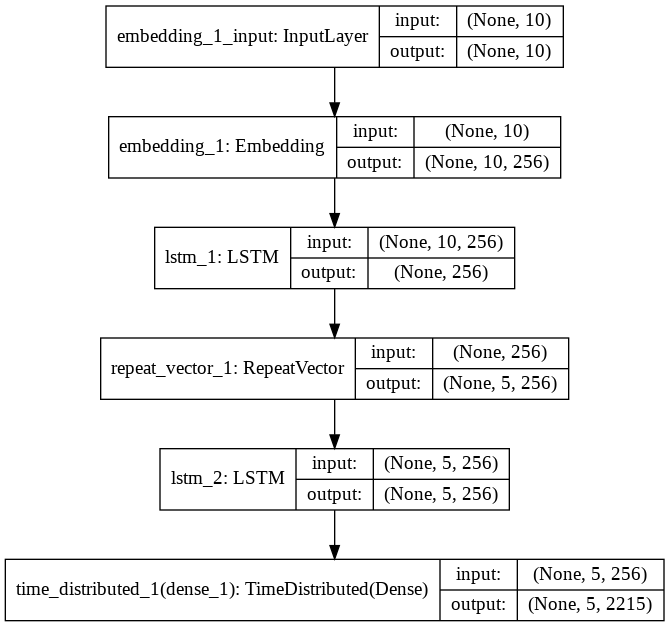

In [20]:
model = define_model(german_vocab_size, english_vocab_size, german_max_length, english_max_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True) 

In [21]:
filename = 'model.h5' 
# hierarchical data format 5
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min') 
# saves model after each epoch
model.fit(trainX, trainY, epochs=50, batch_size= 64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2) 

Train on 9000 samples, validate on 1000 samples
Epoch 1/50
 - 34s - loss: 4.3680 - val_loss: 3.5556

Epoch 00001: val_loss improved from inf to 3.55565, saving model to model.h5
Epoch 2/50
 - 32s - loss: 3.4075 - val_loss: 3.4366

Epoch 00002: val_loss improved from 3.55565 to 3.43662, saving model to model.h5
Epoch 3/50
 - 31s - loss: 3.2588 - val_loss: 3.3166

Epoch 00003: val_loss improved from 3.43662 to 3.31660, saving model to model.h5
Epoch 4/50
 - 31s - loss: 3.1235 - val_loss: 3.2657

Epoch 00004: val_loss improved from 3.31660 to 3.26573, saving model to model.h5
Epoch 5/50
 - 32s - loss: 3.0070 - val_loss: 3.1145

Epoch 00005: val_loss improved from 3.26573 to 3.11454, saving model to model.h5
Epoch 6/50
 - 32s - loss: 2.8538 - val_loss: 3.0011

Epoch 00006: val_loss improved from 3.11454 to 3.00106, saving model to model.h5
Epoch 7/50
 - 31s - loss: 2.7199 - val_loss: 2.8997

Epoch 00007: val_loss improved from 3.00106 to 2.89972, saving model to model.h5
Epoch 8/50
 - 32s 

## Evaluating the Model

In [0]:
from nltk.translate.bleu_score import corpus_bleu

In [0]:
# function to map an integer to word
def word_for_int(integer, tokenizer):
  for word, num in tokenizer.word_index.items():
    if integer == num:
      return word
  return None
  

In [0]:
# function to give uus the translated squence
def predict_seq(model, tokenizer, source):
  prediction = model.predict(source, verbose = 0)[0]
  tokens = [argmax(vector) for vector in prediction] 
  target = []
  for i in tokens:
    word = word_for_int(i, tokenizer)
    if word is None:
      continue
    target.append(word)
  return ' '. join(target)
  

In [0]:
def evaluate_model(model, source_doc, tokenizer, raw_ds):
  reference, prediction = [], []
  for i, source in enumerate(source_doc):
    source = source.reshape(1, source.shape[0])
    translation = predict_seq(model, english_tokenizer, source) 
    tar_seq, src_seq = raw_ds[i]
    if i<10:
      print('source => [%s], target => [%s], predicted => [%s]' % (src_seq, tar_seq, translation))
    reference.append([tar_seq.split()]) 
    # reference must be a list 
    # of doc for evaluation
    prediction.append(translation.split())
    # Calculate BLEU score for
    # automatic evaluation of MT
    # perfect match score : 1
    # mismatch score : 0
  print('BLEU-1: %f' % corpus_bleu(reference, prediction, weights = (1.0, 0, 0, 0))) # cumulative 
  print('BLEU-2: %f' % corpus_bleu(reference, prediction, weights = (0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(reference, prediction, weights = (0.33, 0.33, 0.33, 0)))
  print('BLEU-4: %f' % corpus_bleu(reference, prediction, weights = (0.25, 0.25, 0.25, 0.25)))
    
    

In [35]:
print('Evaluating Training dataset...')
evaluate_model(model, trainX, english_tokenizer, train)
print('Evaluating Testing dataset...')
evaluate_model(model, testX, english_tokenizer, test)

Evaluating Training dataset...
source => [tom half], target => [tom helped], predicted => [tom helped]
source => [ich war zu schuchtern], target => [i was too shy], predicted => [i was too shy]
source => [ich brauche zeit], target => [i want time], predicted => [i want time]
source => [ich stecke fest], target => [im stuck], predicted => [im stuck]
source => [kannst dus nicht], target => [cant you do it], predicted => [cant you do it]
source => [ich werde mit dem auto fahren], target => [ill go by car], predicted => [ill go by car]
source => [wozu ist es gut], target => [what is it for], predicted => [is it for]
source => [warum jetzt aufgeben], target => [why quit now], predicted => [why quit now]
source => [machs morgen], target => [do it tomorrow], predicted => [do it tomorrow]
source => [ich wei das], target => [i know this], predicted => [i know this]
BLEU-1: 0.927685
BLEU-2: 0.895653
BLEU-3: 0.795860
BLEU-4: 0.497123
Evaluating Testing dataset...
source => [tom war gescheit], tar